# INFSCI 0510 Final Exam
- Andrew Noonan
- April 16 2025

Importing libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import FactorAnalysis
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns


loading csv

In [2]:
df = pd.read_csv('credit_card_transactions.csv')

In [3]:
df.isnull().sum()

transaction_id            0
account_number            0
transaction_type          0
transaction_amount        0
account_holder_country    0
purchase_country          0
credit_card_type          0
card_balance              0
card_limit                0
account_holder_income     0
dtype: int64

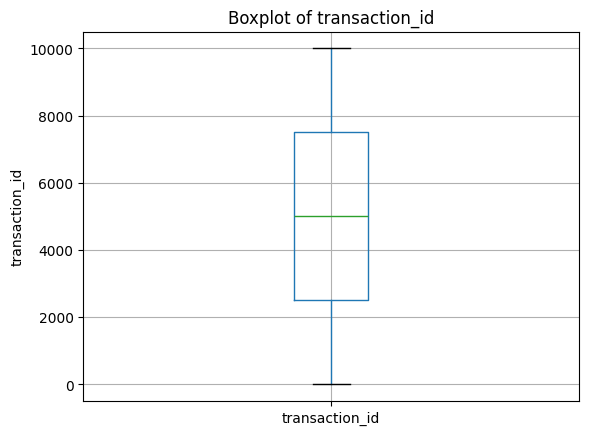

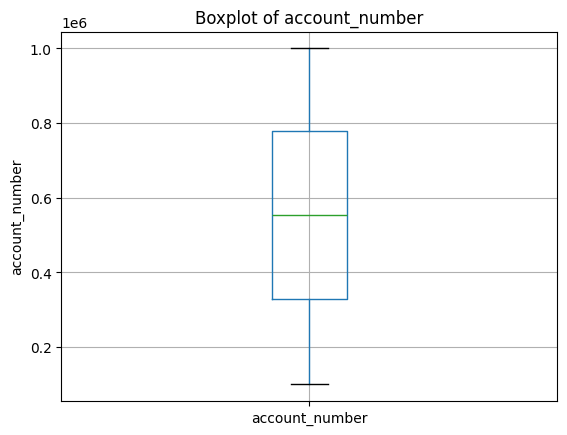

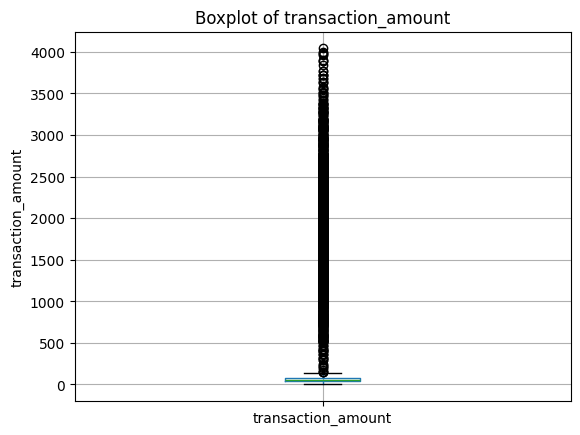

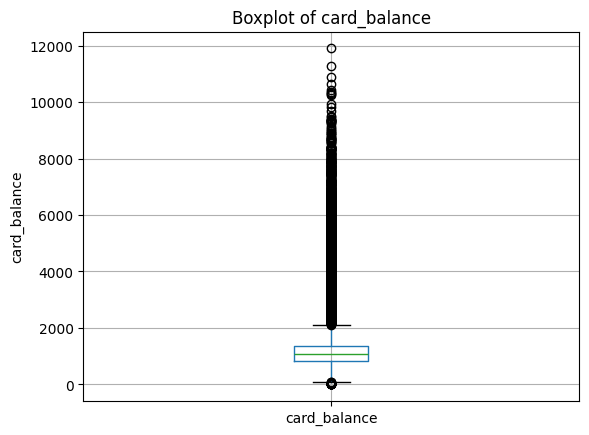

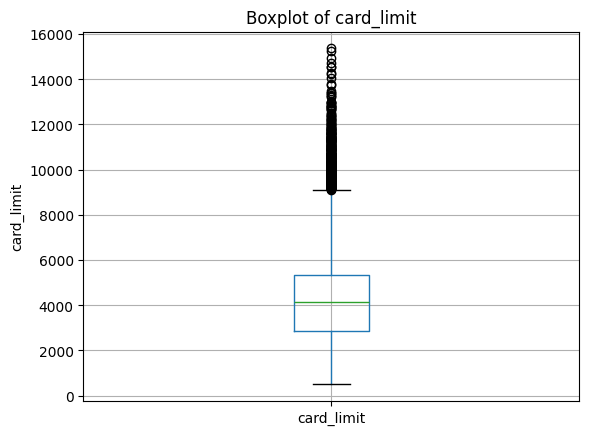

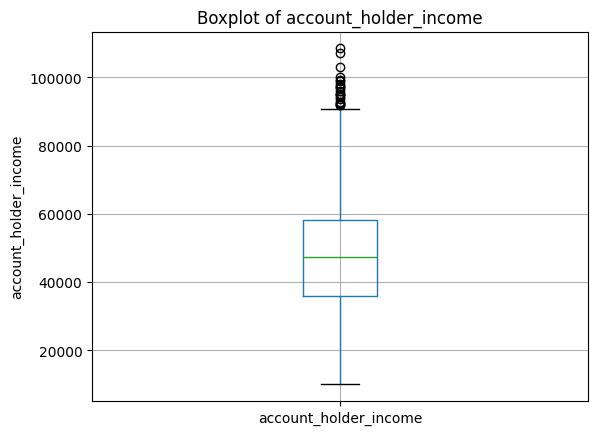

In [4]:
for col in df.select_dtypes(include=np.number).columns:
    plt.figure()  # Create a new figure for each column
    df.boxplot(column=[col])
    plt.title(f'Boxplot of {col}')
    plt.ylabel(col)
    plt.show()

## Task 1: K-Means Clustering

evaluating numeric features

In [5]:
df.head()

,transaction_id,account_number,transaction_type,transaction_amount,account_holder_country,purchase_country,credit_card_type,card_balance,card_limit,account_holder_income
0,1,221958,purchase,89.58,Mexico,Mexico,visa,1169.37,4727.91,69391.21
1,2,771155,cash_withdrawal,19.38,Canada,Canada,amex,1227.37,2651.14,46738.58
2,3,231932,online_payment,1685.34,USA,USA,mastercard,4582.76,7723.90,25337.63
3,4,465838,purchase,53.61,USA,USA,mastercard,928.94,3670.61,47987.03
4,5,359178,purchase,56.41,USA,USA,amex,905.34,5641.75,63439.96


In [6]:
df.dtypes

transaction_id              int64
account_number              int64
transaction_type           object
transaction_amount        float64
account_holder_country     object
purchase_country           object
credit_card_type           object
card_balance              float64
card_limit                float64
account_holder_income     float64
dtype: object

**Numeric features relevant for clustering**
- transaction_amount
- card_balance
- card_limit
- account_holder_income


In [7]:
scaler = StandardScaler()
 

scaling numeric features

In [8]:
df['account_holder_income'] = scaler.fit_transform(df[['account_holder_income']])
df['card_balance'] = scaler.fit_transform(df[['card_balance']])
df['card_limit'] = scaler.fit_transform(df[['card_limit']])
df['transaction_amount'] = scaler.fit_transform(df[['transaction_amount']])

**finding the optimal number of clusters**

In [9]:
data = df[['account_holder_income', 'card_balance', 'card_limit', 'transaction_amount']]
sse = {}
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data)
    data["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_



/tmp/ipykernel_14389/4170478929.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["clusters"] = kmeans.labels_
/tmp/ipykernel_14389/4170478929.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["clusters"] = kmeans.labels_
/tmp/ipykernel_14389/4170478929.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

In [10]:
print(sse)

{1: 40000.0, 2: 17879.057070651754, 3: 15823.296904075954, 4: 10913.166910712322, 5: 9513.467596093822, 6: 8151.77238906085, 7: 7637.979666759884, 8: 7159.260016385579, 9: 6699.353444923168, 10: 6150.665189014164}


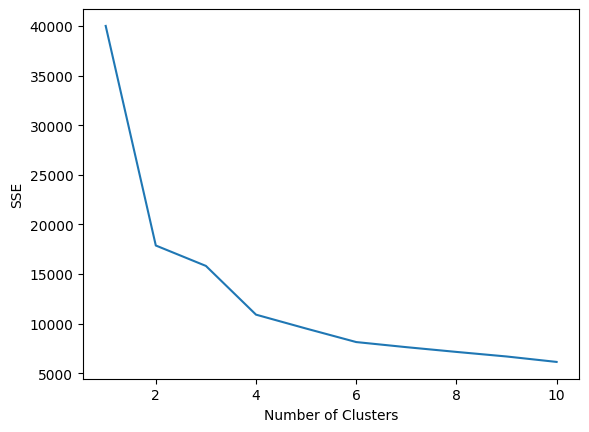

In [11]:
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

**Choosing the number of clusters based on the plot with the elbow method**
- based on the plot, it looks like k=3 would be the best choice for the number of clusters

In [12]:
kmeans = KMeans(n_clusters=3)
kmeans = kmeans.fit(data)
labels = kmeans.predict(data)
print(labels)

[0 1 2 ... 0 0 1]


In [13]:
df = pd.concat([df.reset_index(), pd.Series(labels).rename('fraud_cluster')], axis=1)

In [14]:
df.head()

,index,transaction_id,account_number,transaction_type,transaction_amount,account_holder_country,purchase_country,credit_card_type,card_balance,card_limit,account_holder_income,fraud_cluster
0,0,1,221958,purchase,-0.324700,Mexico,Mexico,visa,-0.248523,0.188132,1.409819,0
1,1,2,771155,cash_withdrawal,-0.424579,Canada,Canada,amex,-0.210902,-0.834921,-0.027763,1
2,2,3,231932,online_payment,1.945711,USA,USA,mastercard,1.965518,1.664008,-1.385910,2
3,3,4,465838,purchase,-0.375878,USA,USA,mastercard,-0.404474,-0.332713,0.051467,1
4,4,5,359178,purchase,-0.371894,USA,USA,amex,-0.419782,0.638305,1.032141,0


## Task 2: PCA Projection

In [15]:
pca = PCA(n_components=2)

In [16]:
principalComponents = pca.fit_transform(data)


In [17]:
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])


In [18]:
principalDf.head()

,principal component 1,principal component 2
0,-2.957855,-0.201750
1,3.120228,-1.207459
2,0.773466,3.397568
3,3.126522,-1.047084
4,-2.879577,-0.002253


In [19]:
df[['fraud_cluster']].head()

,fraud_cluster
0,0
1,1
2,2
3,1
4,0


In [20]:
finalDf = pd.concat([principalDf, df[['fraud_cluster']]], axis = 1)
finalDf.head(5)

,principal component 1,principal component 2,fraud_cluster
0,-2.957855,-0.201750,0
1,3.120228,-1.207459,1
2,0.773466,3.397568,2
3,3.126522,-1.047084,1
4,-2.879577,-0.002253,0


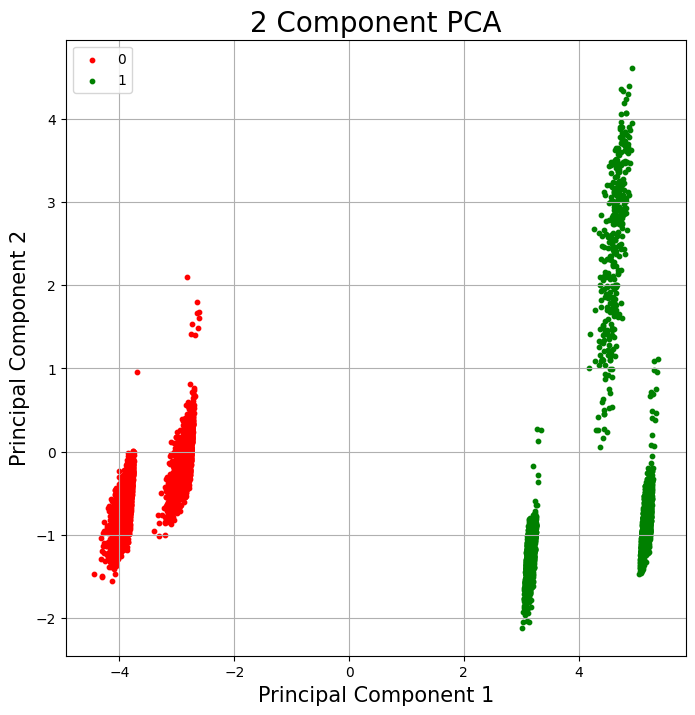

In [21]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)


targets = [0, 1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['fraud_cluster'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 10)
ax.legend(targets)
ax.grid()

The two classes appear very well separated

## Task 3: RandomForest Classification

In [22]:
X = df[['account_holder_income', 'card_balance', 'card_limit', 'transaction_amount']]
y = df['fraud_cluster']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [24]:
model = RandomForestClassifier(random_state=1, max_depth=10)


In [25]:
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=1)

In [26]:
y_pred = model.predict(X_test)
y_pred

array([2, 1, 0, ..., 2, 2, 1], shape=(2000,), dtype=int32)

In [27]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       885
           1       0.99      0.98      0.99       599
           2       0.98      0.99      0.98       516

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000



In [28]:
confusion_matrix(y_test, y_pred)

array([[883,   0,   2],
       [  1, 589,   9],
       [  0,   7, 509]])

**Both the classification report and the confusion matrix show that the model is very accurate at 99%, with slightly more error in classes 0 and 1, with 11 and 8 errors respectively, whereas class 2 had only one error.**

## Task 4: Stratified K-Fold Cross-Validation

In [29]:
kf = KFold(n_splits=10, shuffle=False)
scores = cross_val_score(model, X, y, cv=kf)
print('Cross-validated scores:', scores)
print('Final score: ', scores.mean())

Cross-validated scores: [0.995 0.993 0.992 0.986 0.996 0.994 0.993 0.993 0.993 0.991]
Final score:  0.9926


**Accuracy is slightly worse after K-fold validation, but still quite good**

In [30]:
pred = cross_val_predict(model, X, y, cv=kf)
pred

array([0, 1, 2, ..., 0, 0, 1], shape=(10000,), dtype=int32)

## Task 5:Feature Importances

In [31]:
features = X.columns
print(features)
importances = model.feature_importances_
print(importances)

Index(['account_holder_income', 'card_balance', 'card_limit',
       'transaction_amount'],
      dtype='object')
[0.80894284 0.06110007 0.04287155 0.08708555]


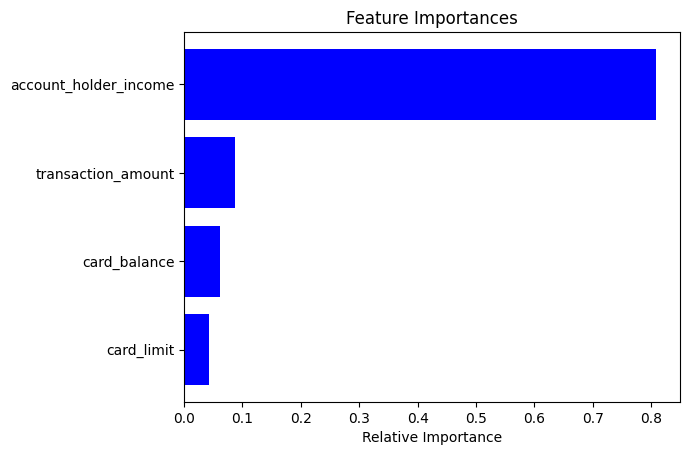

In [32]:
indices = np.argsort(importances)[-4:]
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

**The features that were the most important of the four numeric ones are *account_holder_income* and *card_limit***

If I had to theorize about why this may be the case, I would say it comes down to attractiveness. Those with higher incomes and card limits are more lucrative targets of fraud because the potential gains per fraudulent transaction are greater than those with lower incomes/card limits

## Task 6: Explanations in Reflections

#### Performance of the model
My model's performance is quite strong, with between 98-99% accuracy classifying transactions into one of three clusters, based on account holder income, card limits, transaction amounts, and card balance. Using RandomForest for the model likely contributes to this high accuracy, because unlike some other machine learning models like Naive Bayes, it makes no assumptions about the dependence or independence of features. Additionally, it likely performs well because the provided dataset is very high quality, with respect to the lack of missing values. Even though their are many outliers, RandomForest is highly resistant to outliers because they are unlikely to affect the forecasts of every tree in the forest
#### Usefulness of the model/how it could be used in the real world
I believe that this model could be very useful, because credit card fraud is becoming increasingly costly both for individuals and for corporations. Being able to identify patterns that separate fraudalent transactions from legitimate transactions accurately could result in significant savings for the economy as a whole.
